# Variational Autoencoders

Variational Autoencoders (VAEs) are a type of generative model that learn to encode input data into a compressed representation and then decode it back while ensuring the generated outputs are meaningful and diverse. They are widely used for tasks like image generation, anomaly detection, and data compression.

## How VAEs works

VAEs consist of two main components:

- **Encoder** – Maps input data x to a latent space z (a lower-dimensional representation). Instead of a fixed encoding, it learns a probability distribution over the latent space.
<br>
- **Decoder** – Takes a sample from the latent distribution and reconstructs the original data x ′.
<br>
<br>
Unlike traditional Autoencoders, which directly map input to a fixed latent vector, VAEs introduce probabilistic encoding using a mean 𝜇 and variance σ^2, enforcing continuity in the latent space.

## Dataset Description

The Fashion MNIST contains grayscale images of size 28x28 like t-shirts, dresses, sneakers and bags.

- **Total Images**: 70,000 (60,000 training + 10,000 test)
<br>
- **Number of Classes**: 10 (Different fashion categories)

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from PIL import Image

## Preprocessing Steps

- The dataset is loaded using `tf.keras.datasets.fashion_mnist.load_data()` and is splitted into training and testing sets along with its respective labels.

- The pixel value range from 0 to 255, so it is normalized to range 0 to 1 by dividing it by 255.

- CNNs takes input as 4D tensors (batch_size, height, witdth, channels) so we expand the dimension to include channels i.e 1 in this case.

In [32]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Normalize the pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Expand dimensions to add a channel axis (28x28 -> 28x28x1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [33]:
latent_dim = 8
beta = 2.0
learning_rate = 1e-4
batch_size = 32
epochs = 50

## Encoder architecture

**Input Layer :**
<br>
- Takes input images of size 28x28x1


**First Convolution Layer :**
<br>
- We have 32 filters in the first convolution layer with kernel size of 3 and activation function **Relu** with stride downsampling of 2.

**Second Convolution Layer :**
<br>
- The second convolutional layer increases filters to 64, maintaining the 3×3 kernel, ReLU activation, stride of 2, and same padding, reducing the size to (7, 7, 64)

**Third Convolution Layer :**
- The third convolutional layer further expands to 128 filters, again using a 3×3 kernel, ReLU activation, stride of 2, and same padding, resulting in (4, 4, 128).

**Fourth convolution Layer :**
- The fourth convolutional layer reaches 256 filters, with the same parameters, compressing the output to (2, 2, 256) and then Batch Noramlization is applied to stabilize training followed by Dropout layer to prevent overfitting.

**Flattened Layer :**
- The output is then flattened into a 1D vector (1024 units), which is passed through a dense layer of 16 neurons with ReLU activation.

**Dense Layer :**
- The latent space representation is defined using two separate dense layers: z_mean, which represents the center of the latent space, and z_log_var, which captures its variance.

**Sampling Layer :**
- Finally, a sampling layer applies the reparameterization trick, generating z by adding a small random noise (epsilon) to allow smooth backpropagation, producing the final latent vector.



In [51]:
encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, 3, activation='relu', strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)


# Reparameterization Trick: Sample a point from the latent space distribution
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Lambda layer to apply the reparameterization trick
z = tf.keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
# Define the encoder model with inputs and outputs (z_mean, z_log_var, and sampled z)
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

## Decoder architecture

**Input Layer :**

- The latent input layer takes a latent vector of size (latent_dim,), which represents the compressed feature space.

**Dense Layer :**

- This vector is first passed through a dense layer with 7 × 7 × 256 neurons and ReLU activation.

**Reshape Layer :**

- The reshape layer then converts this 1D vector into a (7, 7, 256) tensor, effectively preparing it for upsampling.

**First Transposed Convolution Layer :**

- The first transposed convolutional layer applies 128 filters with a 3×3 kernel, ReLU activation, stride of 2, and same padding, upsampling the feature map to (14, 14, 128).

**Second Transposed Convolution Layer :**

- This uses 64 filters with same kernel size, activation function and strides and therfore upsamples the image to (28, 28, 64).

**Third Transposed Convolution Layer :**

- The third transposed convolutional layer has 32 filters with a 3×3 kernel and ReLU activation, but without striding, keeping the spatial size (28, 28, 32).

**Output Layer :**

-  The output layer uses a single filter with a 3×3 kernel, sigmoid activation, and same padding, producing a (28, 28, 1) grayscale image where each pixel value is normalized between 0 and 1.

In [52]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(latent_inputs)
x = layers.Reshape((7, 7, 256))(x)
x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')

## Training Steps

- Initialize VAE by taking encoder and decoder as input.
- Define three losses i.e total loss (reconstruction loss + KL loss), reconstruction loss (Tracks how well the decoder reconstructs the original input), KL divergence (ensures a well-formed latent space).
- Returns a list of metrics that are updated during training, helping to monitor model performance.
- Extracts inputs from the dataset (ignoring labels _ since VAEs are unsupervised).
- Passes input through the encoder, obtaining:
z_mean: The mean of the latent distribution.
z_log_var: The logarithm of the variance of the latent distribution.
z: The sampled latent vector using the reparameterization trick.
- Passes z through the decoder to reconstruct the input.
- Uses binary cross-entropy loss between the original input and the reconstructed output. Summed across pixels to measure overall reconstruction accuracy. Averaged across the batch to get the final reconstruction loss.
- The KL divergence loss ensures the latent space follows a Gaussian distribution.
- Updates the loss metrics to track training performance.
- Returns the latest loss values as a dictionary for logging.

## Testing Steps

- Similar to train_step, but no gradient calculation is needed.
- Computes reconstruction loss and KL loss exactly like in train_step.
- Returns a dictionary containing test loss values.

In [53]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        inputs, _ = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(inputs)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(inputs, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + 0.1 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        inputs, _ = data
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(inputs, reconstruction),
                axis=(1, 2)
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total_loss = reconstruction_loss + 0.1 * kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

- Creates an instance of the VAE class, using the previously defined encoder and decoder models.
- This VAE model will be trained to learn an efficient latent space representation and reconstruct input images.
- Implements an exponential decay learning rate:
<br>
**initial_learning_rate=1e-3:** Starts training with a learning rate of 0.001.
<br>
**decay_steps=10000:** The learning rate is updated after every 10,000 steps.
<br>
**decay_rate=0.96:** After every 10,000 steps, the learning rate is multiplied by 0.96, gradually reducing it.
<br>
**staircase=True:** Learning rate decreases in discrete steps, rather than smoothly.

In [54]:
# Create an instance of the VAE model using the encoder and decoder
vae = VAE(encoder, decoder)

# Define an exponential learning rate decay schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
history = vae.fit(x_train, x_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(x_test, x_test))

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - kl_loss: 31.4618 - reconstruction_loss: 334.6881 - total_loss: 337.8342 - val_kl_loss: 31.8440 - val_loss: 232.1016 - val_reconstruction_loss: 228.9172
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - kl_loss: 31.0892 - reconstruction_loss: 239.6005 - total_loss: 242.7095 - val_kl_loss: 28.6533 - val_loss: 223.8422 - val_reconstruction_loss: 220.9769
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - kl_loss: 29.0568 - reconstruction_loss: 233.4082 - total_loss: 236.3140 - val_kl_loss: 27.9505 - val_loss: 220.3525 - val_reconstruction_loss: 217.5575
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - kl_loss: 28.5566 - reconstruction_loss: 229.8823 - total_loss: 232.7381 - val_kl_loss: 28.3774 - val_loss: 216.4600 - val_reconstruction_loss: 213.6223
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - kl_loss: 28.9832 - reconstruction_loss: 227.1484 - total_loss: 230.0468 - val_kl_loss: 28.3932 - val_loss:

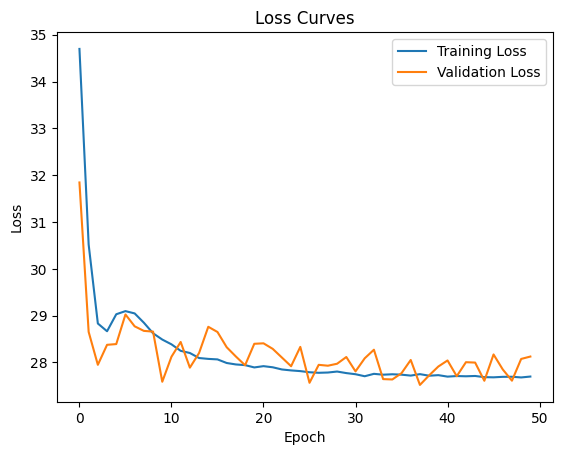

In [55]:
  plt.plot(history.history['kl_loss'], label='Training Loss')
  plt.plot(history.history['val_kl_loss'], label='Validation Loss')
  plt.legend()
  plt.title('Loss Curves')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

- It selects 10 test images, displays them in the first row.
- Generates reconstructed versions using the encoder and decoder, displaying them in the second row.
- The encoder extracts a compressed representation (latent space), and the decoder reconstructs the image from this representation.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


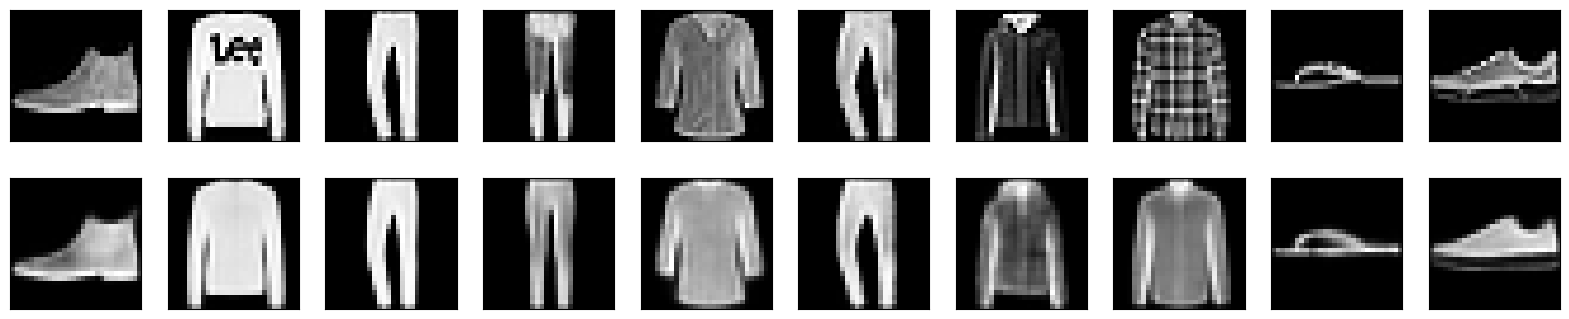

In [56]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    z_mean, z_log_var, _ = encoder.predict(x_test[i][np.newaxis, ...])
    reconstruction = decoder.predict(z_mean)
    plt.imshow(reconstruction[0].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

- The encoder processes the test images (x_test) and outputs their latent space representations (z_mean).
- **pca = PCA(n_components=2):** Initializes PCA to reduce the latent space to 2 dimensions.
- **z_pca = pca.fit_transform(z_mean):** Transforms the latent representations (z_mean) into a 2D space for visualization.
- Plots each data point using PCA-transformed latent space coordinates.
- Colors correspond to the original class labels (y_test), using the 'tab10' colormap for better distinction.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


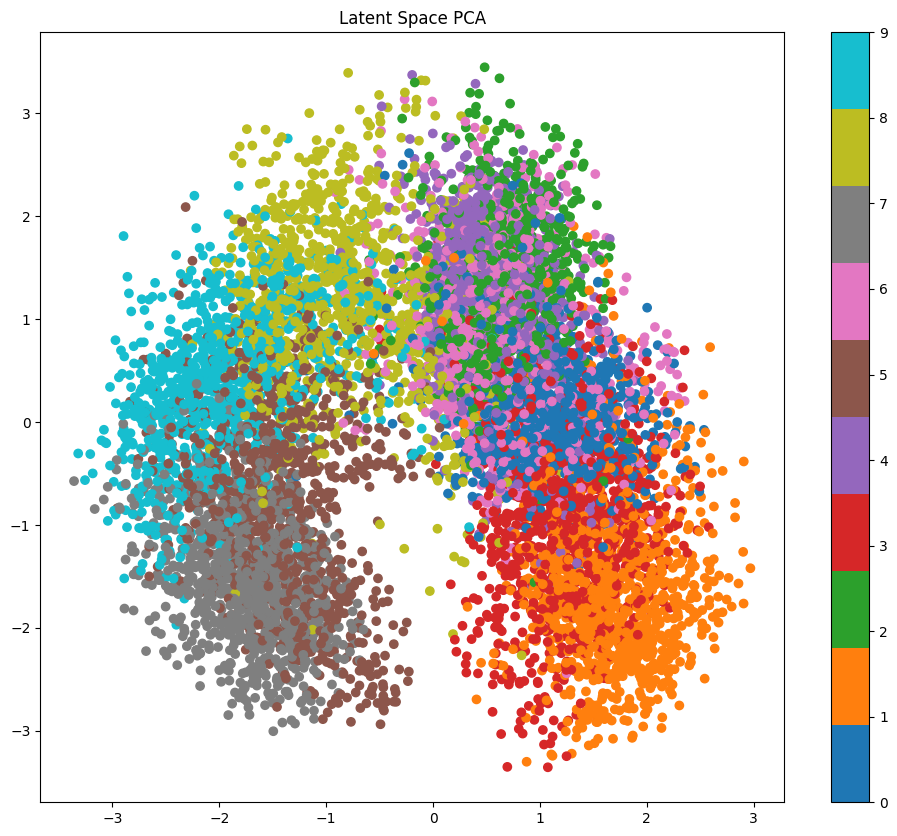

In [57]:
# Encode the test dataset to obtain the latent representations (z_mean)
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
# Apply Principal Component Analysis (PCA) to reduce latent dimensions to 2D for visualization
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)
# Plot the latent space in 2D
plt.figure(figsize=(12, 10))
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.title('Latent Space PCA')
plt.show()

- n = 10: Specifies that 10 images will be generated and displayed.
- Samples a random point from a Gaussian distribution in the latent space.
- Passes the sampled latent vector to the decoder to generate an image.
- Displays the generated grayscale image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


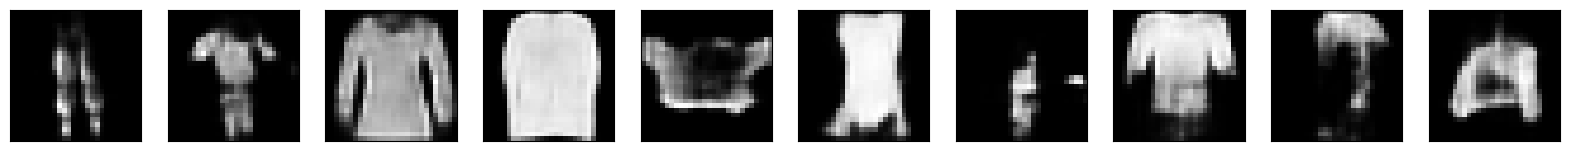

In [58]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    # Sample a random latent vector from a normal distribution
    z_sample = np.random.normal(size=(1, latent_dim))
    # Generate an image from the latent vector using the decoder
    generated = decoder.predict(z_sample)
    plt.imshow(generated[0].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Conclusion

- Applied l2 regularization to all the convolution layers with rate 1e-4.
- Too much regularization on convolutional layers reduced feature extraction power.
- The results are worse than the previous ones.
- Used Kl beta (beta = 2.0)
